In [1]:
import agama
import arepo
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

from joblib import Parallel, delayed
import matplotlib as mpl

from numba import njit

agama.setUnits(mass=1E10, length=1, velocity=1)

'Length unit: 1 Kpc, velocity unit: 1 km/s, time unit: 977.793 Myr, mass unit: 1e+10 Msun, gravitational constant: 43009.2'

In [2]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Acceleration'],
              basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/home01/abeane/starbar/plots/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [3]:
snap_list = np.arange(0, 1600, 50)

In [4]:
import glob
def read_pattern_speed(freq_path, name, lvl, snap):
    frq = h5.File(freq_path + '/freq_' + name + '-' + lvl + '/freq_' + name + '-' + lvl + '.' + \
             str(0)+'.hdf5', mode='r')
    ans = np.array(frq['PatternSpeed'][snap])
    frq.close()
    return ans

In [5]:
freq_path = '/n/home01/abeane/starbar/plots/freq/data'

ps_N = read_pattern_speed(freq_path, 'Nbody', 'lvl3', snap_list)
ps_S = read_pattern_speed(freq_path, 'phantom-vacuum-Sg20-Rc3.5', 'lvl3', snap_list) 

In [6]:
def get_E_Lz(idx, sim_idx, Nbody=False):
    sn = read_snap(idx, sim_idx, lvl='lvl3', parttype=1, 
               fields=['Coordinates', 'ParticleIDs', 'Velocities', 'Potential'])

    if Nbody:
        center = np.array([0., 0., 0.])
    else:
        center = np.array([200., 200., 200.])

    pos = sn.part1.pos.value - center
    vel = sn.part1.vel.value
    phi = sn.part1.pot.value

    E = phi + 0.5 * np.square(np.linalg.norm(vel, axis=1))
    Lz = np.cross(pos, vel)[:,2]
    Ltot = np.linalg.norm(np.cross(pos, vel), axis=1)
    
    return E, Lz

In [7]:
def read_agama_pot(idx, name, lvl):
    base = '/n/home01/abeane/starbar/plots/agama_pot/data/'
    fname = base + 'pot_' + name + '-' + lvl + '/pot_' + name + '-' + lvl + '.' + str(idx) + '.txt'
    return agama.Potential(fname)

In [8]:
from scipy.optimize import minimize

def _to_minimize(E, Op, pot):
    return np.abs((Op - 2.*np.pi/pot.Tcirc(E)))

def compute_E_CR(pot, Op):
    ans = minimize(_to_minimize, -1E5, args=(Op, pot))
    return ans.x[0]

In [9]:
E0, Lz0 = get_E_Lz(snap_list[0], 1, Nbody=False)
E10, Lz10 = get_E_Lz(snap_list[10], 1, Nbody=False)
E20, Lz20 = get_E_Lz(snap_list[20], 1, Nbody=False)
E30, Lz30 = get_E_Lz(snap_list[30], 1, Nbody=False)

E0N, Lz0N = get_E_Lz(snap_list[0], 0, Nbody=True)
E10N, Lz10N = get_E_Lz(snap_list[10], 0, Nbody=True)
E20N, Lz20N = get_E_Lz(snap_list[20], 0, Nbody=True)
E30N, Lz30N = get_E_Lz(snap_list[30], 0, Nbody=True)

In [10]:
pot0 = read_agama_pot(snap_list[0], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')
pot10 = read_agama_pot(snap_list[10], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')
pot20 = read_agama_pot(snap_list[20], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')
pot30 = read_agama_pot(snap_list[30], 'phantom-vacuum-Sg20-Rc3.5', 'lvl3')

pot0N = read_agama_pot(snap_list[0], 'Nbody', 'lvl3')
pot10N = read_agama_pot(snap_list[10], 'Nbody', 'lvl3')
pot20N = read_agama_pot(snap_list[20], 'Nbody', 'lvl3')
pot30N = read_agama_pot(snap_list[30], 'Nbody', 'lvl3')

ECR_0 = compute_E_CR(pot0, ps_S[0])
ECR_10 = compute_E_CR(pot10, ps_S[10])
ECR_20 = compute_E_CR(pot20, ps_S[20])
ECR_30 = compute_E_CR(pot30, ps_S[30])

ECR_0N = compute_E_CR(pot0N, ps_N[0])
ECR_10N = compute_E_CR(pot10N, ps_N[10])
ECR_20N = compute_E_CR(pot20N, ps_N[20])
ECR_30N = compute_E_CR(pot30N, ps_N[30])

/n/home01/abeane/.local/lib/python3.6/site-packages/scipy/optimize/optimize.py:1166: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (np.dot(yk, sk))


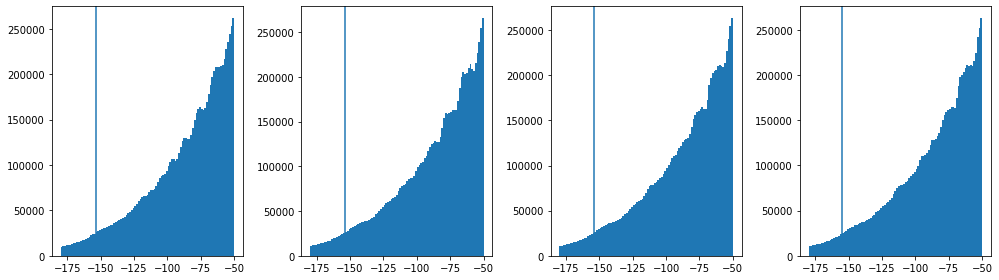

In [13]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4))

bins = np.linspace(-180, -50, 100)

ax[0].hist(E0/1000.0, bins=bins)
ax[1].hist(E10/1000.0, bins=bins)
ax[2].hist(E20/1000.0, bins=bins)
ax[3].hist(E30/1000.0, bins=bins)

ax[0].axvline(ECR_0/1000.0)
ax[1].axvline(ECR_10/1000.0)
ax[2].axvline(ECR_20/1000.0)
ax[3].axvline(ECR_30/1000.0)

fig.tight_layout()

plt.show()

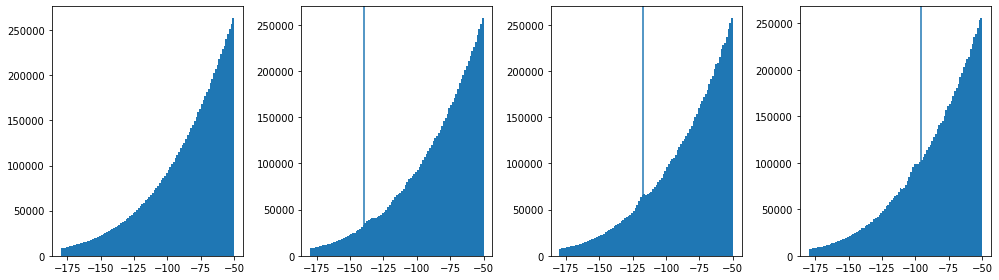

In [26]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4))

bins = np.linspace(-180, -50, 100)

ax[0].hist(E0N/1000.0, bins=bins)
ax[1].hist(E10N/1000.0, bins=bins)
ax[2].hist(E20N/1000.0, bins=bins)
ax[3].hist(E30N/1000.0, bins=bins)

# ax[0].axvline(ECR_0N/1000.0)
ax[1].axvline(ECR_10N/1000.0)
ax[2].axvline(ECR_20N/1000.0)
ax[3].axvline(ECR_30N/1000.0)

fig.tight_layout()

plt.show()

In [25]:
E0N

array([ -609.58124805,  -626.61257339,  -606.5053037 , ...,
       -1653.4198139 , -1639.54394684, -1638.58341266])

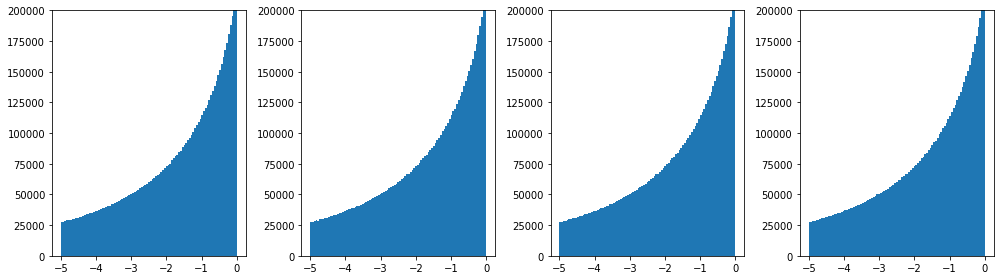

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4))

bins = np.linspace(-5, 0, 100)

ax[0].hist(Lz0/1000.0, bins=bins)
ax[1].hist(Lz10/1000.0, bins=bins)
ax[2].hist(Lz20/1000.0, bins=bins)
ax[3].hist(Lz30/1000.0, bins=bins)

# ax[0].axvline(ECR_0/1000.0)
# ax[1].axvline(ECR_10/1000.0)
# ax[2].axvline(ECR_20/1000.0)
# ax[3].axvline(ECR_30/1000.0)

for x in ax:
    x.set_ylim(0, 200000)

fig.tight_layout()

plt.show()

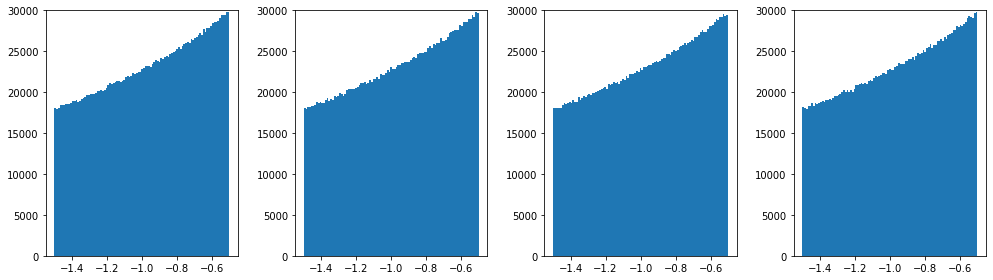

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(14, 4))

bins = np.linspace(-1.5, -0.5, 100)

ax[0].hist(Lz0/1000.0, bins=bins)
ax[1].hist(Lz10/1000.0, bins=bins)
ax[2].hist(Lz20/1000.0, bins=bins)
ax[3].hist(Lz30/1000.0, bins=bins)

# ax[0].axvline(ECR_0/1000.0)
# ax[1].axvline(ECR_10/1000.0)
# ax[2].axvline(ECR_20/1000.0)
# ax[3].axvline(ECR_30/1000.0)

for x in ax:
    x.set_ylim(0, 30000)

fig.tight_layout()

plt.show()